# Yelp Exploration

In [3]:
%matplotlib inline
import os
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import *
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA
from sklearn import mixture
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn import preprocessing

from functools import reduce
from mpl_toolkits.mplot3d import Axes3D
from nltk.stem import PorterStemmer

import requests
import json
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import MeasureControl
from folium.plugins import Fullscreen
from folium.plugins import FastMarkerCluster
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

from functools import reduce
from mpl_toolkits.mplot3d import Axes3D
from nltk.stem import PorterStemmer

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint


In [4]:
%%time
# reviews = pd.read_csv('input/yelp_review.csv') # will take over 2 minutes
reviews = pd.read_csv('input/yelp_review.csv', nrows=10000) # essentially instant

CPU times: user 74.9 ms, sys: 15 ms, total: 89.9 ms
Wall time: 101 ms


In [5]:
%%time
businesses = pd.read_csv('input/yelp_business.csv')

CPU times: user 606 ms, sys: 82 ms, total: 688 ms
Wall time: 715 ms


In [6]:
%%time
attributes = pd.read_csv('input/yelp_business_attributes.csv', 
                             dtype='category', na_values='Na', true_values='True', false_values='False')
attribute_names = attributes.drop('business_id', axis=1).columns
attributes[attribute_names] = attributes[attribute_names].apply(lambda x: x.cat.codes)

CPU times: user 1.37 s, sys: 118 ms, total: 1.48 s
Wall time: 1.52 s


In [7]:
joined = businesses.merge(attributes, on='business_id').set_index('business_id')
joined.head()

,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,...,Corkage,DietaryRestrictions_dairy-free,DietaryRestrictions_gluten-free,DietaryRestrictions_vegan,DietaryRestrictions_kosher,DietaryRestrictions_halal,DietaryRestrictions_soy-free,DietaryRestrictions_vegetarian,AgesAllowed,RestaurantsCounterService
business_id,,,,,,,,,,,,,,,,,,,,,
FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
o9eMRCWt5PkpLDE0gOPtcQ,"""Messina""",NaN,"""Richterstr. 11""",Stuttgart,BW,70567,48.727200,9.147950,4.0,5,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


## EDA

Before starting the supervised machine learning, let us do some basic exploratory data analysis.  First let's take a look at what information we have in the `reviews` data frame.

In [8]:
reviews.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


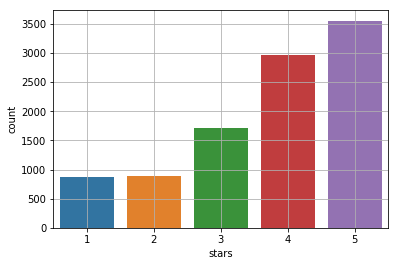

In [9]:
sns.countplot('stars', data=reviews)
plt.grid()
plt.show()

There is some right skew in the star ratings.  We will leave this alone for now and come back to it in the **Predicting Stars with Review Text** section.  For geographical separation, we run KMeans and visualize on maps in the last section.

We're going to join businesses and attributes now.  Businesses without listed attributes and the converse will be excluded by the inner join.

In [10]:
joined = businesses.merge(attributes, on='business_id').set_index('business_id')
joined.head()

,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,...,Corkage,DietaryRestrictions_dairy-free,DietaryRestrictions_gluten-free,DietaryRestrictions_vegan,DietaryRestrictions_kosher,DietaryRestrictions_halal,DietaryRestrictions_soy-free,DietaryRestrictions_vegetarian,AgesAllowed,RestaurantsCounterService
business_id,,,,,,,,,,,,,,,,,,,,,
FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
o9eMRCWt5PkpLDE0gOPtcQ,"""Messina""",NaN,"""Richterstr. 11""",Stuttgart,BW,70567,48.727200,9.147950,4.0,5,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


## Extracting Categories

The categories in the `businesses` data frame is useful to us.  However, it is currently in the form of semicolon separated values.  In addition, the categories for each business do not seem to be ordered in any way.  Consider that restaurants are probably the most popular type of business on Yelp, but the "restaurant" label is not necessarily first (or even near the top) of the category list for any given applicable business.  Therefore, we will do some preprocessing to extract all the categories and sort them by popularity, i.e. frequency of appearance in businesses.

In [11]:
c = Counter()
joined.categories.str.split(';').apply(lambda x: c.update(x))

print('Total number of business: %d' % joined.shape[0])

n_categories = len(c.keys())
print('Total number of categories: %d' % n_categories)

Total number of business: 152041
Total number of categories: 1269


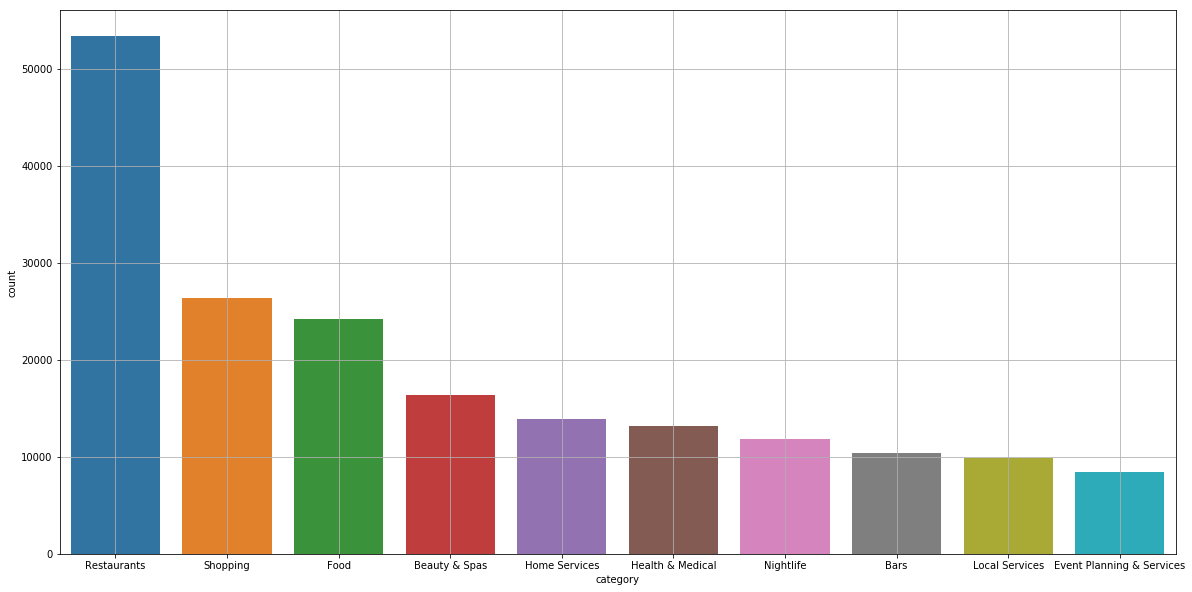

In [12]:
categories = pd.DataFrame.from_dict(c, orient='index').reset_index()
categories.columns = ['category', 'count']
categories = categories.sort_values('count', ascending=False)

plt.figure(figsize=[20,10])
sns.barplot(x='category', y='count', data=categories.iloc[:10])
plt.grid()
plt.show()

Unsurprisingly, the most popular category is restaurants by quite a large margin.

Now, we want to pull out the first few categories as "main categories for each business.  To do this, we

1. Split the categories
2. Sort the categories by descending count
3. Rejoin the categories
4. Split the categories into separate columns
5. Extract the first 3 columns

Admitedly, there seems to be some inefficiency between steps 3 and 4.  I am currently unsure of how to do it better.

In [13]:
main_categories = joined.categories.str.split(';')\
    .apply(lambda row: ';'.join(sorted(row, key=lambda x:-c[x]))).\
    str.split(';', expand=True)\
    [[0,1,2]]

main_categories.columns = ['category1', 'category2', 'category3']
attributes_categories = pd.concat([joined, main_categories], axis=1)
attributes_categories.head()

,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,...,DietaryRestrictions_vegan,DietaryRestrictions_kosher,DietaryRestrictions_halal,DietaryRestrictions_soy-free,DietaryRestrictions_vegetarian,AgesAllowed,RestaurantsCounterService,category1,category2,category3
business_id,,,,,,,,,,,,,,,,,,,,,
FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,...,-1,-1,-1,-1,-1,-1,-1,Health & Medical,Dentists,General Dentistry
He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,...,-1,-1,-1,-1,-1,-1,-1,Beauty & Spas,Hair Salons,Hair Stylists
8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,...,-1,-1,-1,-1,-1,-1,-1,Shopping,Sporting Goods,None
PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,...,-1,-1,-1,-1,-1,-1,-1,Restaurants,Nightlife,Bars
o9eMRCWt5PkpLDE0gOPtcQ,"""Messina""",NaN,"""Richterstr. 11""",Stuttgart,BW,70567,48.727200,9.147950,4.0,5,...,-1,-1,-1,-1,-1,-1,-1,Restaurants,Italian,None


## Section 1 - Predicting Stars with Business Attributes

In this section, we will aim to identify features in the Business Attributes section that are associated with high ratings on Yelp. This would allow us to answer questions of the type "How important is it for a fast food restaurant to offer delivery?" or "Should my business offer validated parking?". We will do some baseline tests using common machine learning methods to give us a sense of typical performance, and then focus on two methods in more detail - Principal Component Analysis and Logistic Regression.

For the purposes of identifying key features that would allow us to provide business advice, we would have to use Logistic Regression, but we also want to look at PCA as a preprocessing step. PCA causes us to lose visibility into the relative importance of each feature, but it still allows us to use a variety of models to predict rating from a given set of features. We want to explore some of those and see what degree of accuracy we can achieve.

We'll make the assumption throughout that we have only been provided with training data, and that there is a separate test set that we don't have access to at the moment. This means that we will split our data into training and development sets, but not set aside a test data set.

In [14]:
np.random.seed(0)
X_train_attr, X_test_attr, y_train_attr, y_test_attr = \
    train_test_split(joined[attribute_names].values, joined.stars.astype(np.int8).values, test_size=.1)

### Initial Benchmarking Tests  
  
  #### a) Decision Tree

In [15]:
%%time

dt = DecisionTreeClassifier()
dt.fit(X_train_attr, y_train_attr)

print(metrics.classification_report(y_test_attr, dt.predict(X_test_attr), digits=3))

             precision    recall  f1-score   support

          1      0.333     0.002     0.004       528
          2      0.429     0.041     0.075      2130
          3      0.419     0.386     0.402      4992
          4      0.371     0.632     0.467      5275
          5      0.368     0.228     0.282      2280

avg / total      0.393     0.386     0.347     15205

CPU times: user 1.06 s, sys: 23.2 ms, total: 1.08 s
Wall time: 1.09 s


#### b) Random Forest

In [16]:
%%time

rf = RandomForestClassifier()
rf.fit(X_train_attr, y_train_attr)

print(metrics.classification_report(y_test_attr, rf.predict(X_test_attr), digits=3))

             precision    recall  f1-score   support

          1      0.000     0.000     0.000       528
          2      0.438     0.041     0.076      2130
          3      0.420     0.387     0.403      4992
          4      0.371     0.633     0.468      5275
          5      0.368     0.228     0.282      2280

avg / total      0.383     0.387     0.348     15205

CPU times: user 1.7 s, sys: 30.3 ms, total: 1.73 s
Wall time: 1.73 s


#### c) Naive Bayes

In [17]:
%%time

nb = MultinomialNB()
nb.fit(X_train_attr+1, y_train_attr) # have to add 1 to X_train_attr because NB doesn't like negative numbers

print(metrics.classification_report(y_test_attr, nb.predict(X_test_attr+1), digits=3))

             precision    recall  f1-score   support

          1      0.104     0.036     0.054       528
          2      0.313     0.087     0.137      2130
          3      0.426     0.380     0.402      4992
          4      0.392     0.406     0.399      5275
          5      0.291     0.576     0.387      2280

avg / total      0.367     0.365     0.349     15205

CPU times: user 85 ms, sys: 68.4 ms, total: 153 ms
Wall time: 147 ms


### PCA analysis for the attributes database

Explained variance by component


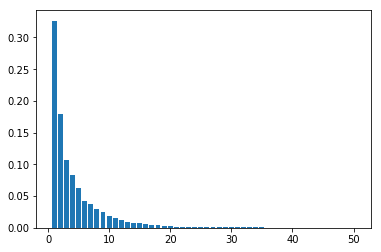


Explained variance up to...


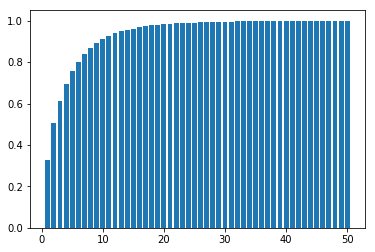

In [27]:
y_atts = pd.Series([int(x) for x in joined['stars']]) #round star ratings
x_atts = joined[joined.columns[12:]] #all the business attributes
x_atts_train, x_atts_dev, y_atts_train, y_atts_dev = train_test_split(x_atts, y_atts, test_size=.1, random_state=0)
pca = PCA()
pca.fit(x_atts_train)
print('Explained variance by component')
plt.bar(height = pca.explained_variance_ratio_[0:50], x = list(range(1,51)))
plt.show()
accrued = []
print()
print('Explained variance up to...')
for k in range(1,51):
    accrued.append(reduce(lambda x,y: x + y, pca.explained_variance_ratio_[0:k]))
plt.bar(height = accrued, x = list(range(1,51)))    
plt.show()

Graphic representation of the attributes more correlated with the component factors


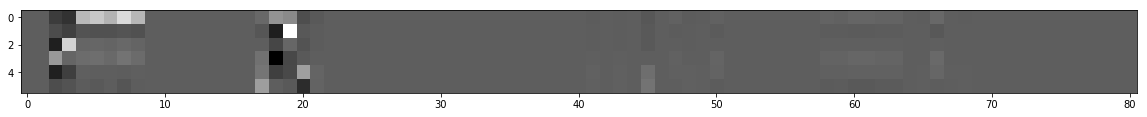

In [28]:
pca = PCA(n_components = 6)
pca.fit(x_atts_train)
factor_loadings = pca.components_.T*np.sqrt(pca.explained_variance_)
print('Graphic representation of the attributes more correlated with the component factors')
plt.figure(figsize=(20,10))
plt.imshow(factor_loadings.T, cmap='gray', interpolation='none')
plt.show()

In [29]:
df_fl = pd.DataFrame(factor_loadings, index = x_atts.columns.values, columns = range(1,7))
print('Ten most important attributes')
print(df_fl.applymap(abs).mean(axis = 1).sort_values(ascending = False)[0:10])

Ten most important attributes
WheelchairAccessible          0.219099
BikeParking                   0.211453
BusinessAcceptsCreditCards    0.205705
BusinessParking_garage        0.197596
BusinessParking_valet         0.143153
Alcohol                       0.125506
BusinessParking_validated     0.118363
BusinessParking_street        0.102119
GoodForKids                   0.100974
HairSpecializesIn_coloring    0.099376
dtype: float64


0


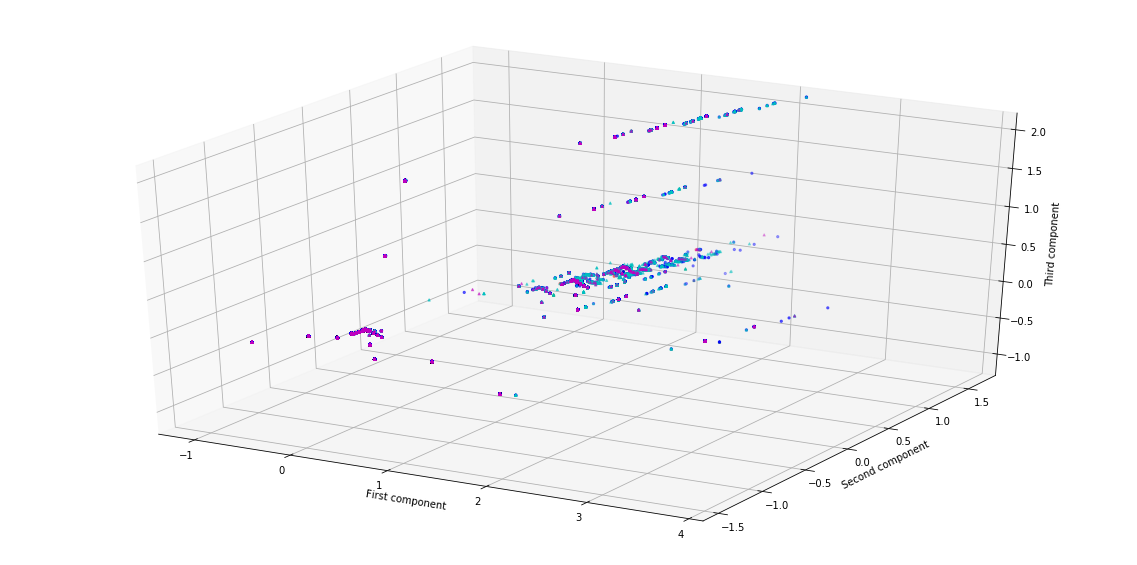

In [30]:
pca = PCA(n_components = 3)
td = pca.fit_transform(x_atts_train)
star_1 = td[y_atts_train == 1]
star_2 = td[y_atts_train == 2]
star_3 = td[y_atts_train == 3]
star_4 = td[y_atts_train == 4]
star_5 = td[y_atts_train == 5]
print(star_1.shape[0]+star_2.shape[0]+star_3.shape[0]+star_4.shape[0]+star_5.shape[0]-td.shape[0]) #check that calculations are correct

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

for c, m, star in [('r', 'o', star_1), ('g', '^', star_2), ('b', 'o', star_3), ('c', '^', star_4), ('m', '^', star_5)]:
    xs = star[:,0]
    ys = star[:,1]
    zs = star[:,2]
    ax.scatter(xs, ys, zs, c=c, marker=m, s=5, zdir = 'x')

ax.set_xlabel('First component')
ax.set_ylabel('Second component')
ax.set_zlabel('Third component')

plt.show()

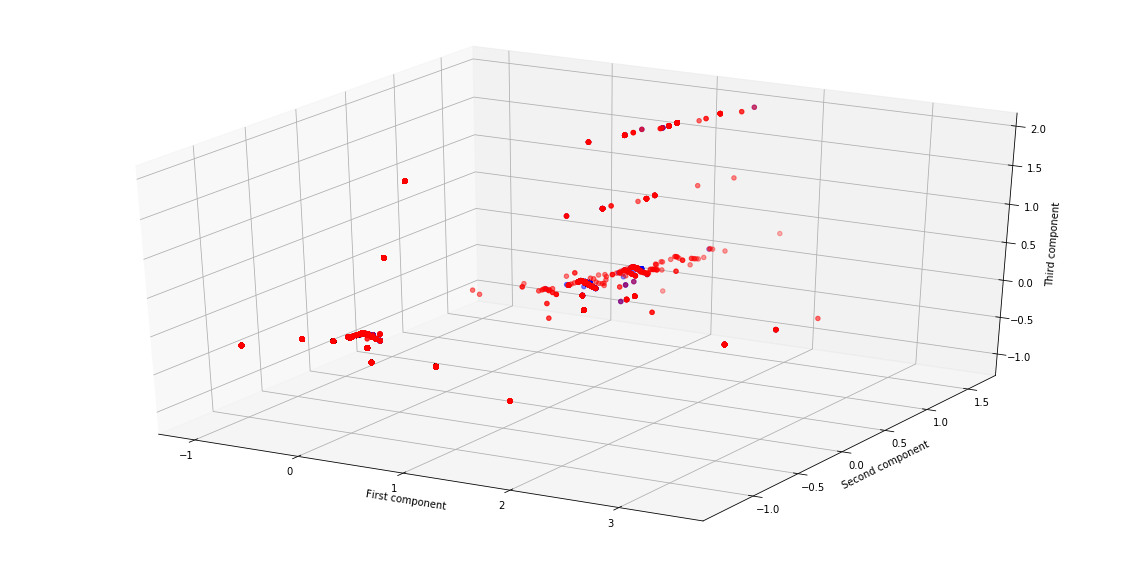

In [31]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

for c, m, star in [('b', 'o', star_1), ('r', 'o', star_5)]:
    xs = star[:,0]
    ys = star[:,1]
    zs = star[:,2]
    ax.scatter(xs, ys, zs, c=c, marker=m, s=20, zdir = 'x')

ax.set_xlabel('First component')
ax.set_ylabel('Second component')
ax.set_zlabel('Third component')

plt.show()

Visually, it doesn't seems that there's a way to separate the star rating by the content of the attributes. But it could be that there is a solution in higher dimensions or using non linear models.

### Predictive model using only PCA components

#### a) Gaussian mixtures

Data will be binarized by setting 1-2 as 1 and 4-5 as 5, 3s are dropped from the sample.

In [32]:
cov_mat = ['spherical', 'diag', 'tied', 'full']
n_GMM = [6,4,3,2]
acc = []
y_atts_dev = y_atts_dev.reset_index(drop = True)
x_atts_dev = x_atts_dev.reset_index(drop = True)
bin_y_atts_dev = y_atts_dev[(y_atts_dev<3) | (y_atts_dev>3)].apply(lambda x: 1 if x <3 else 5)
bin_x_atts_dev = x_atts_dev[(y_atts_dev<3) | (y_atts_dev>3)]

for k in range(0,len(cov_mat)):
    for i in range(0,len(n_GMM)):
        pca = PCA(n_components = 6)
        td = pca.fit_transform(x_atts_train)
        neg = td[y_atts_train < 3]
        pos = td[y_atts_train > 3]
        tst = pca.fit_transform(bin_x_atts_dev)
        clf = mixture.GaussianMixture(n_components = n_GMM[i], covariance_type = cov_mat[k], random_state = 0)
        clf_td_pos = clf.fit(pos)
        tst_mat_pos = np.exp(clf_td_pos.score_samples(tst))
        clf_td_neg = clf.fit(neg)
        tst_mat_neg = np.exp(clf_td_neg.score_samples(tst))
        y_pred = [5 if tst_mat_pos[j] > tst_mat_neg[j] else 1 for j in range(0,len(tst_mat_pos))]
        num = [1 if y_pred[j] == bin_y_atts_dev.iloc[j] else 0 for j in range(0,len(y_pred))]
        acc.append(sum(num)/len(y_pred))
mx = acc.index(max(acc))
a = mx//4
b = mx-a*4
print('Maximum accuracy was ', acc[mx], "\n", "It was achieved using 6 PCA components, ", n_GMM[b], " GMM components, with a ", cov_mat[a], " covariance matrix.")

Maximum accuracy was  0.7272104180945853 
 It was achieved using 6 PCA components,  4  GMM components, with a  full  covariance matrix.


#### b) Support Vector Machine

In [33]:
#Using all labels
print('All labels')
svc = LinearSVC()
svc.fit(td, y_atts_train)
tst = pca.fit_transform(x_atts_dev)
print(metrics.classification_report(y_atts_dev, svc.predict(tst)))
print()
print('Binarized data')
bin_td = td[(y_atts_train<3) | (y_atts_train>3)]
bin_y_atts_train = y_atts_train[(y_atts_train<3) | (y_atts_train>3)].apply(lambda x: 1 if x <3 else 5)
svc.fit(bin_td, bin_y_atts_train)
bin_tst = pca.fit_transform(bin_x_atts_dev)
print(metrics.classification_report(bin_y_atts_dev, svc.predict(bin_tst)))


All labels
             precision    recall  f1-score   support

          1       0.00      0.00      0.00       528
          2       0.00      0.00      0.00      2130
          3       0.38      0.33      0.35      4992
          4       0.35      0.64      0.45      5275
          5       0.36      0.17      0.23      2280

avg / total       0.30      0.36      0.31     15205


Binarized data
             precision    recall  f1-score   support

          1       0.48      0.02      0.04      2658
          5       0.74      0.99      0.85      7555

avg / total       0.68      0.74      0.64     10213



#### c) Gaussian Naive Bayes

In [34]:
gnb = GaussianNB()
gnb = gnb.fit(td, y_atts_train)
y_pred = gnb.predict(tst)
print("Classification report for GaussianNB - All labels")
print(metrics.classification_report(y_atts_dev,y_pred))
gnb = gnb.fit(bin_td, bin_y_atts_train)
y_pred = gnb.predict(bin_tst)
print("Classification report for GaussianNB - Binarized data")
print(metrics.classification_report(bin_y_atts_dev,y_pred))

Classification report for GaussianNB - All labels
             precision    recall  f1-score   support

          1       0.09      0.04      0.06       528
          2       0.16      0.07      0.10      2130
          3       0.41      0.36      0.38      4992
          4       0.37      0.37      0.37      5275
          5       0.28      0.54      0.37      2280

avg / total       0.33      0.34      0.33     15205

Classification report for GaussianNB - Binarized data
             precision    recall  f1-score   support

          1       0.31      0.10      0.15      2658
          5       0.74      0.92      0.82      7555

avg / total       0.63      0.71      0.65     10213



#### d) Decision Tree

In [35]:
%%time

dt = DecisionTreeClassifier()
dt.fit(td, y_atts_train)
print("Classification report for Decision Tree - All labels")
print(metrics.classification_report(y_atts_dev, dt.predict(tst)))
dt.fit(bin_td, bin_y_atts_train)
print("Classification report for Decision Tree - Binarized data")
print(metrics.classification_report(bin_y_atts_dev, dt.predict(bin_tst)))

Classification report for Decision Tree - All labels
             precision    recall  f1-score   support

          1       0.05      0.20      0.08       528
          2       0.21      0.02      0.04      2130
          3       0.40      0.25      0.31      4992
          4       0.36      0.59      0.45      5275
          5       0.35      0.19      0.25      2280

avg / total       0.34      0.33      0.30     15205

Classification report for Decision Tree - Binarized data
             precision    recall  f1-score   support

          1       0.28      0.22      0.24      2658
          5       0.75      0.81      0.77      7555

avg / total       0.62      0.65      0.64     10213

CPU times: user 172 ms, sys: 9.86 ms, total: 182 ms
Wall time: 179 ms


#### e) Random Forest

In [36]:
%%time

rf = RandomForestClassifier()
rf.fit(td, y_atts_train)
print("Classification report for Random Forest - All labels")
print(metrics.classification_report(y_atts_dev, rf.predict(tst)))
rf.fit(bin_td, bin_y_atts_train)
print("Classification report for Random Forest - Binarized data")
print(metrics.classification_report(bin_y_atts_dev, rf.predict(bin_tst)))

Classification report for Random Forest - All labels
             precision    recall  f1-score   support

          1       0.05      0.18      0.08       528
          2       0.24      0.03      0.06      2130
          3       0.37      0.35      0.36      4992
          4       0.38      0.50      0.43      5275
          5       0.35      0.20      0.25      2280

avg / total       0.34      0.33      0.32     15205

Classification report for Random Forest - Binarized data
             precision    recall  f1-score   support

          1       0.33      0.00      0.00      2658
          5       0.74      1.00      0.85      7555

avg / total       0.63      0.74      0.63     10213

CPU times: user 715 ms, sys: 35.6 ms, total: 750 ms
Wall time: 747 ms


#### f) Logistic Regression

In [37]:
%%time

lr = LogisticRegression(penalty='l1', C=2)
lr.fit(td, y_atts_train)
print("Classification report for Logistic regression - All labels")
print(metrics.classification_report(y_atts_dev, lr.predict(tst)))
lr.fit(bin_td, bin_y_atts_train)
print("Classification report for Logistic regression - Binarized data")
print(metrics.classification_report(bin_y_atts_dev, lr.predict(bin_tst)))

Classification report for Logistic regression - All labels
             precision    recall  f1-score   support

          1       0.00      0.00      0.00       528
          2       0.00      0.00      0.00      2130
          3       0.39      0.30      0.33      4992
          4       0.35      0.68      0.46      5275
          5       0.36      0.17      0.23      2280

avg / total       0.30      0.36      0.30     15205

Classification report for Logistic regression - Binarized data
             precision    recall  f1-score   support

          1       0.48      0.02      0.04      2658
          5       0.74      0.99      0.85      7555

avg / total       0.68      0.74      0.64     10213

CPU times: user 573 ms, sys: 44.1 ms, total: 617 ms
Wall time: 611 ms


### Predictive model using only Linear Regression 

After reducing the dimensionality of the data and then binarizing ratings into "good" and "bad, we achieved some reasonable results in terms of f1 score for the positive class. Let's see how we do using Logistic Regression. The overall goal is optimize the model so that we have a fairly high degree of accuracy, and then we can examine which features are most strongly associated with a high rating. Note that we could have used Multinomial Logistic Regression to predict ratings on the full 1 to 5 scale, but for the purposes of this exercise we are not really interested in targeting a specific star rating - instead we are looking for features that a business might want to add (or remove) in order to improve their overall Yelp rating.

#### Data preparation

In [38]:
# Use 1 to represent good reviews (which are 4, 4.5 or 5 stars), and 0 to represent poor reviews (1, 1.5, 2 or 2.5 star)
# We will remove 3 and 3.5 star reviews, because we are not interested in features that lead to a mediocre rating.

# Cut out mediocre ratings (make a copy to be sure original DF is untouched in case anyone else needs it)
attributes_categories_bin = attributes_categories.loc[(attributes_categories['stars'] >= 4) | (attributes_categories['stars'] < 3)].copy()

# Add new label for good / bad
attributes_categories_bin["GoodReview"] = np.where(attributes_categories_bin['stars'] >= 4, 1, 0)

# Set up data sets
X, Y = attributes_categories_bin[attributes_categories_bin.columns[12:-4]], attributes_categories_bin["GoodReview"]

# Blanks in dataset are represented by -1. Assume that no information is equivalent to lack of a feature
# We'll need booleans later on for some of the feature selection techniques, so we need to eliminate negatives
X = X.replace(-1, 0)

# Split into training and dev
X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size= 0.1, random_state = 127)


Take a look at the training set

92254


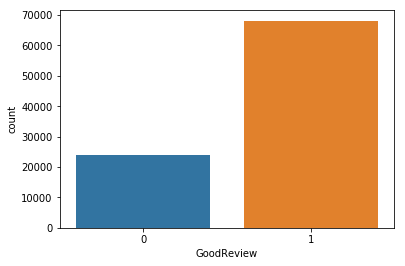

In [39]:
print(len(Y_train))
sns.countplot(Y_train)
plt.show()

So, if we just predicted good for everything, we'd end up with roughly 73% accuracy - ideally we would want to beat that if possible, but the main focus is to understand which features are most important.

#### Function to rank most significant features

In [40]:
# First, define a function that makes it easier to pull out features with the largest coefficients
# The coef_ attribute is an array of log odds, so convert them to odds by taking the exponent before
# selecting the n largest ones. Using np.partition and np.argpartition doesn't lead to sorted results
# so we need an additional argsort. Assumes that we have a fitted model called lr and training data
# is called X_train.

def get_n_best_features(n):
    """Get the n largest coefficients and use their indices to pull out the corresponding feature"""   
    weights = np.exp(lr.coef_)
    max_weights = np.partition(weights, -n)[:, -n:]
    indices = np.argpartition(weights, -n)[:, -n:]

    # Apply indices to X_Train.columns to get feature names, combine those with weights
    # and sort the result in descending order based on the weight column, before printing
    temp = np.column_stack((X_train.columns[indices][0],max_weights.T))
    paired = temp[np.argsort(-temp[:, 1])]
    for p in range(n):
        print("{0} has odds ratio {1:.2f}".format(paired[p][0], paired[p][1]))
        

#### Training

In [41]:
# Start with default settings, which will mean L2 regularization. We want that, since we are interested
# in feature importance (using L1 would allow for zero coefficients, and tends to lead to sparse solutions)

lr = LogisticRegression()
lr.fit(X_train, Y_train)
print("Most significant features: \n")
get_n_best_features(10)
print('\n', metrics.classification_report(Y_dev, lr.predict(X_dev)))

Most significant features: 

Open24Hours has odds ratio 4.87
GoodForMeal_breakfast has odds ratio 4.23
CoatCheck has odds ratio 3.89
DietaryRestrictions_kosher has odds ratio 3.32
BusinessParking_validated has odds ratio 2.74
GoodForMeal_dinner has odds ratio 2.73
GoodForMeal_brunch has odds ratio 2.61
GoodForMeal_latenight has odds ratio 2.38
BikeParking has odds ratio 2.28
BestNights_wednesday has odds ratio 1.79

              precision    recall  f1-score   support

          0       0.78      0.07      0.13      2656
          1       0.75      0.99      0.86      7595

avg / total       0.76      0.75      0.67     10251



The important features are interesting and seem to make sense. It is plausible that features such as Open24hours, CoatCheck and GoodForBreakfast would be associated with popular venues. There could be a degree of collinearity (eg "Good for Breakfast" is probably correlated with "Good for Brunch"), but we will come back to feature selection later. Unfortunately the scores aren't significantly different from what we'd expect from just predicting "Good" for everything. The very low recall for predicting "Poor" reviews drags down the f1. Can we improve things by tuning?

#### Tuning

In [42]:
lr = GridSearchCV(LogisticRegression(penalty='l2'), {'C': [.001, .005, .01, 0.5, .1, .5, 1, 2, 5]})
lr.fit(X_train, Y_train)
print('\nBest parameters: ' + str(lr.best_params_))
print("Best score is", lr.best_score_)


Best parameters: {'C': 0.5}
Best score is 0.7511219025733301


In [43]:
lr = LogisticRegression(penalty='l2', C = 0.5)
lr.fit(X_train, Y_train)
print("\nMost significant features: \n")
get_n_best_features(10)
print('\n', metrics.classification_report(Y_dev, lr.predict(X_dev)))


Most significant features: 

GoodForMeal_breakfast has odds ratio 3.99
Open24Hours has odds ratio 3.84
CoatCheck has odds ratio 3.16
GoodForMeal_dinner has odds ratio 2.74
BusinessParking_validated has odds ratio 2.73
GoodForMeal_brunch has odds ratio 2.40
DietaryRestrictions_kosher has odds ratio 2.31
BikeParking has odds ratio 2.28
GoodForMeal_latenight has odds ratio 2.07
BusinessAcceptsCreditCards has odds ratio 1.75

              precision    recall  f1-score   support

          0       0.78      0.07      0.13      2656
          1       0.75      0.99      0.86      7595

avg / total       0.76      0.75      0.67     10251



Strengthening the regularization (C is inverse of alpha, so lower C means more regularization) had little effect on the metrics. The top 10 features are largely unchanged, although their relative weighting has shifted so the ordering changed. Best Night Wednesday dropped out, to be replaced by Accepts Credit Cards.
The model still has low recall when predicting poor reviews. This could be because the training sample isn't balanced. We could fix that by reweighting.

In [44]:
lr = LogisticRegression(penalty='l2', C=0.5, class_weight='balanced')
lr.fit(X_train, Y_train)
print("\nMost significant features: \n")
get_n_best_features(10)
print('\n', metrics.classification_report(Y_dev, lr.predict(X_dev)))


Most significant features: 

Open24Hours has odds ratio 4.57
GoodForMeal_breakfast has odds ratio 4.31
CoatCheck has odds ratio 3.77
DietaryRestrictions_kosher has odds ratio 2.96
GoodForMeal_dinner has odds ratio 2.73
BusinessParking_validated has odds ratio 2.69
GoodForMeal_brunch has odds ratio 2.65
GoodForMeal_latenight has odds ratio 2.36
BikeParking has odds ratio 2.28
BusinessAcceptsCreditCards has odds ratio 1.75

              precision    recall  f1-score   support

          0       0.32      0.62      0.42      2656
          1       0.80      0.55      0.65      7595

avg / total       0.68      0.57      0.59     10251



Reweighting the training observations helped increase the recall and f1 for poor ratings, and the precision for good ratings, but pulled everything else down. The top 10 features remained the same. Since our primary focus is on the good rating, where there was only a 5 point gain precision for a 45 point loss in recall, the trade off doesn't seem worth it, so we'll revert to the original training set without balancing the class weights.  
  
  
One thing that is becoming apparent though is that there may be a bias towards features that relate to restaurants.

We're sticking with L2 regularization, meaning that we are assigning some weight to all features, even those with limited relevance. There are 81 features in the raw data set. Let's eliminate some of those using a univariate signifance test.

#### Feature selection

In [45]:
# Use a chi^2 test to select the 20 features that have the strongest relationship with the output
# variable (ie a good rating). We can then train the model on the reduced feature set
X_new_train = SelectKBest(chi2, k=20).fit_transform(X_train, Y_train)
X_new_dev = SelectKBest(chi2, k=20).fit_transform(X_dev, Y_dev)

In [46]:
lr = LogisticRegression(penalty='l2', C=0.5)
lr.fit(X_new_train, Y_train)
print("\nMost significant features: \n")
get_n_best_features(10)
print('\n', metrics.classification_report(Y_dev, lr.predict(X_new_dev)))


Most significant features: 

HairSpecializesIn_asian has odds ratio 3.64
WheelchairAccessible has odds ratio 3.55
RestaurantsPriceRange2 has odds ratio 3.05
BusinessAcceptsCreditCards has odds ratio 2.60
HairSpecializesIn_extensions has odds ratio 2.53
BikeParking has odds ratio 2.26
HairSpecializesIn_straightperms has odds ratio 2.26
BusinessParking_lot has odds ratio 2.01
HairSpecializesIn_kids has odds ratio 1.89
ByAppointmentOnly has odds ratio 1.55

              precision    recall  f1-score   support

          0       0.05      0.00      0.00      2656
          1       0.74      1.00      0.85      7595

avg / total       0.56      0.74      0.63     10251



This is the first time that we've seen features related to hairdressing, which means that they may be good predictors since they were selected by the chi^2 test, but we haven't seen them before because they get outweighed by the greater number of restaurant reviews. This suggests that we should slice the dataset by category, but before we do that, let's examine the impact of feature selection on the full dataset.  

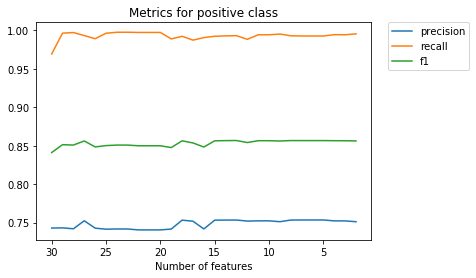

In [47]:
Krange = list(range(2,31))
precision, recall, f1 = [], [], []

# Fit a model using k best features, where k is between 30 and 2
# For each iteration, calculate and store key metrics and then plot the results
for K in Krange:
    X_new_train = SelectKBest(chi2, k=K).fit_transform(X_train, Y_train)
    X_new_dev = SelectKBest(chi2, k=K).fit_transform(X_dev, Y_dev)
    lr = LogisticRegression(penalty='l2', C=0.5)
    lr.fit(X_new_train, Y_train)
    precision.append(metrics.precision_score(Y_dev, lr.predict(X_new_dev)))
    recall.append(metrics.recall_score(Y_dev, lr.predict(X_new_dev)))
    f1.append(metrics.f1_score(Y_dev, lr.predict(X_new_dev)))

plt.title("Metrics for positive class")
plt.xlabel("Number of features")
plt.gca().invert_xaxis()
plt.plot(Krange,precision, label = "precision")
plt.plot(Krange,recall, label = 'recall')
plt.plot(Krange,f1, label = "f1")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

Reducing k in the Select K features function improves performance slightly, but it has a limited impact. There is a minor improvement once you reduce features below 16, but it is marginal. This could be because there is not enough information contained in the attributes. One thing to note is that they are all generally positive in nature (eg say for instance a business received low ratings because it was closed during peak hours, there would be no way to detect that through the set of available attributes. Businesses open all day could be flagged "Open 24 Hours" but everything else would full into "not open 24 hours", regardless of whether it led to a negative rating or not) 

####  Training on a specific category  
Several attributes are category specific eg 'HairSpecializesIn_curly' only applies to hair salons, but we are training a model for multiple categories using that attribute for each one and then looking at the overall results to select which features are most important. That may not matter for decision trees (presumably they would quickly find categories with low information gain), but let's check by seeing how things look if we focus on a single category at a time.

In [48]:
# Examine a selection of the main categories
main_cats = ['Restaurants', "Shopping", 'Food', 'Nightlife']

for cat in main_cats:
    # Slice the data and create required sets
    subset = attributes_categories_bin.loc[attributes_categories['category1'] == cat]
    X, Y = subset[subset.columns[12:-4]], subset["GoodReview"]
    X = X.replace(-1, 0)
    X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size= 0.1, random_state = 127)
    
    # Train LR model and print the 5 most important attributes
    lr = LogisticRegression(penalty='l2', C=0.5)
    lr.fit(X_train, Y_train)
    print("\n5 most significant features for {0}: \n".format(cat))
    get_n_best_features(5)
    print("f1 score = {0:.2f}".format(metrics.f1_score(Y_dev, lr.predict(X_dev))))



5 most significant features for Restaurants: 

BusinessParking_validated has odds ratio 3.86
GoodForMeal_breakfast has odds ratio 3.62
CoatCheck has odds ratio 2.87
DietaryRestrictions_kosher has odds ratio 2.79
GoodForMeal_dinner has odds ratio 2.78
f1 score = 0.83

5 most significant features for Shopping: 

BusinessParking_validated has odds ratio 3.84
WheelchairAccessible has odds ratio 3.39
HasTV has odds ratio 2.89
BusinessParking_street has odds ratio 2.21
BikeParking has odds ratio 1.98
f1 score = 0.84

5 most significant features for Food: 

BestNights_monday has odds ratio 4.40
BusinessParking_validated has odds ratio 3.09
BikeParking has odds ratio 2.22
BusinessParking_valet has odds ratio 1.79
BusinessAcceptsCreditCards has odds ratio 1.66
f1 score = 0.89

5 most significant features for Nightlife: 

BusinessParking_garage has odds ratio 2.24
WheelchairAccessible has odds ratio 2.16
BusinessParking_valet has odds ratio 1.93
BusinessAcceptsCreditCards has odds ratio 1.45
Op

These features seem to make sense and f1 scores are reasonable (this is for the positive class). Good for Breakfast, Dinner and Brunch now only show up in the Restaurant category. However, some of these include multiple entries for parking, which is clearly important, but they are taking up multiple slots and could introduce some colinearlity. As a final step, rerun the exercise but remove some of the parking attributes so that only the most important, BusinessParking_validated, remains (note that there are also a large number of bars are tagged with "HairSpecializesIn_coloring" - on the basis that this is almost certainly an error and unlikley to be important to any business other than hair salons, that column will be removed as well).

#### Adjust to remove potential collinearity

In [49]:
main_cats = ['Restaurants', "Shopping", 'Food', 'Nightlife']
duplicate_parking = ['BusinessParking_garage','BusinessParking_street','BusinessParking_lot', 'BusinessParking_valet', 'HairSpecializesIn_coloring']

for cat in main_cats:
    # Slice the data, remove additional parking columns, and create required sets
    subset = attributes_categories_bin.loc[attributes_categories['category1'] == cat]
    subset = subset.drop(duplicate_parking, axis=1)
    X, Y = subset[subset.columns[12:-4]], subset["GoodReview"]
    X = X.replace(-1, 0)
    X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size= 0.1, random_state = 127)
    
    # Train LR model and print the 5 most important attributes
    lr = LogisticRegression(penalty='l2', C=0.5)
    lr.fit(X_train, Y_train)
    print("\n5 most significant features for {0}: \n".format(cat))
    get_n_best_features(5)
    print("f1 score = {0:.2f}".format(metrics.f1_score(Y_dev, lr.predict(X_dev))))


5 most significant features for Restaurants: 

GoodForMeal_breakfast has odds ratio 4.75
BusinessParking_validated has odds ratio 3.51
GoodForMeal_dinner has odds ratio 3.43
CoatCheck has odds ratio 3.24
GoodForMeal_brunch has odds ratio 2.78
f1 score = 0.83

5 most significant features for Shopping: 

BusinessParking_validated has odds ratio 3.93
WheelchairAccessible has odds ratio 3.42
HasTV has odds ratio 2.89
BikeParking has odds ratio 1.98
Open24Hours has odds ratio 1.67
f1 score = 0.84

5 most significant features for Food: 

BestNights_monday has odds ratio 4.37
BusinessParking_validated has odds ratio 3.17
BikeParking has odds ratio 2.25
BusinessAcceptsCreditCards has odds ratio 1.66
RestaurantsDelivery has odds ratio 1.58
f1 score = 0.89

5 most significant features for Nightlife: 

WheelchairAccessible has odds ratio 2.08
Open24Hours has odds ratio 1.43
BusinessAcceptsCreditCards has odds ratio 1.43
BikeParking has odds ratio 1.11
Ambience_divey has odds ratio 1.00
f1 score 

Although the f1 scores haven't improved, we get more visibility into the most important features because potential duplicates have been removed. With the odd exeption (which seem to be driven by misclassifications in the underlying data set, eg bars with TV's that were tagged as "Shopping" rather than "Bars"), the most significant features appear relevant and useful for the purpose of discussing specific features that are associated with good Yelp ratings.

#### Regional differences between the US and the EU  
  
  We'll take a look at whether the features associated with a good review differ between the US and the EU for the categories Restaurants and Food (Food is similar but typically more casual dining).

In [50]:
main_cats = ['Restaurants', "Food"]
duplicate_parking = ['BusinessParking_garage','BusinessParking_street','BusinessParking_lot', 'BusinessParking_valet', 'HairSpecializesIn_coloring']
regions = ["the Americas", 'the EU']
for cat in main_cats:
    for reg in regions:
        # Slice the data, remove additional parking columns
        subset = attributes_categories_bin.loc[attributes_categories['category1'] == cat]
        subset = subset.drop(duplicate_parking, axis=1)
        
        # Split based on longitude, which is reasonable for this dataset, but we'd need to adjust if there were
        # more reviews from South America, Asia or Africa
        if reg == "the Americas":
            subset = subset[subset['longitude']<-50]
        else:
            subset = subset[subset['longitude']>-50]
        X, Y = subset[subset.columns[12:-4]], subset["GoodReview"]
        X = X.replace(-1, 0)
        X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size= 0.1, random_state = 127)

        # Train LR model and print the 5 most important attributes
        lr = LogisticRegression(penalty='l2', C=0.5)
        lr.fit(X_train, Y_train)
        print("\n5 most significant features for {0} in {1}: \n".format(cat, reg))
        get_n_best_features(5)
        print("f1 score = {0:.2f}".format(metrics.f1_score(Y_dev, lr.predict(X_dev))))


5 most significant features for Restaurants in the Americas: 

GoodForMeal_breakfast has odds ratio 5.47
CoatCheck has odds ratio 3.75
GoodForMeal_dinner has odds ratio 3.61
BusinessParking_validated has odds ratio 3.46
GoodForMeal_latenight has odds ratio 3.27
f1 score = 0.83

5 most significant features for Restaurants in the EU: 

BusinessParking_validated has odds ratio 4.39
OutdoorSeating has odds ratio 2.16
WheelchairAccessible has odds ratio 1.87
DietaryRestrictions_kosher has odds ratio 1.47
GoodForMeal_dinner has odds ratio 1.38
f1 score = 0.93

5 most significant features for Food in the Americas: 

BusinessParking_validated has odds ratio 3.55
BestNights_monday has odds ratio 3.41
BikeParking has odds ratio 2.38
BusinessAcceptsCreditCards has odds ratio 1.56
WiFi has odds ratio 1.49
f1 score = 0.89

5 most significant features for Food in the EU: 

BikeParking has odds ratio 2.54
HappyHour has odds ratio 1.35
RestaurantsReservations has odds ratio 1.17
WheelchairAccessible 

So, it looks as though when Americans go to a restaurant, they prefer a coat check, late night dining and also places that serve breakfast. Europeans tend to favor restaurants for dinner rather than breakfast, and outdoor seating is important (this certainly sounds right to me, as someone who has lived in both places).  
When it comes to casual dining, Americans are looking for WiFi and a place that accepts credit cards, whereas Europeans are more interested in table service and Happy Hour.

## Section 2 - Predicting Stars with Review Text

In this section we will predict the star rating associated with each review text.  First, here is some reminder of what the reviews look like overall.  Recall that this data from only the first 10000 rows of data.  However, we have no reason to believe that the entire reviews dataset is not homogeneous.

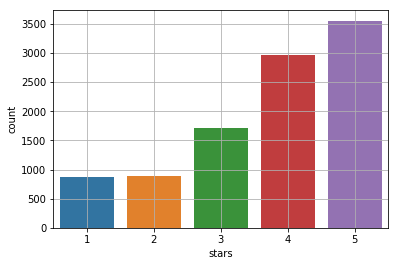

Mean star rating: 3.74


In [51]:
sns.countplot(reviews.stars)
plt.grid()
plt.show()

print('Mean star rating: %.2f' % reviews.stars.mean())

Star ratings tend to be skewed left and the average star rating is 3.74.  If humans were better at rating things objectively, we'd expect an average star rating around 2.5.

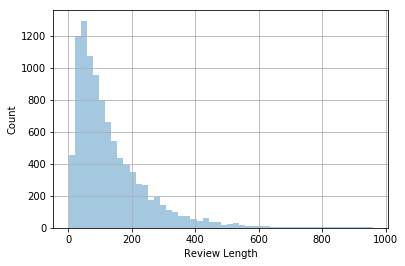

Mean review length: 133.74


In [52]:
reviews['word_count'] = reviews.text.str.split().apply(len)

sns.distplot(reviews.word_count, kde=False)
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.grid()
plt.show()

print('Mean review length: %.2f' % reviews.word_count.mean())

Unsurprisingly, review lengths are skewed right.  Most people are just leaving short blurbs, while a select emotioned individuals are writing essays.  Let's take a look at an example of a review from each star rating.  We'll just look at short ones for now, so we don't have to read any of the aforementioned essays.

In [53]:
def get_random_review(star, max_length=150):
    return reviews[(reviews.stars == star) & (reviews.word_count < max_length)].sample(1).text.values[0]

np.random.seed(4)
for star in range(1,6):
    print('%d star review:' % star)
    print(get_random_review(star))
    print('\n\n\n')

1 star review:
This place is not my favorite pest control. Even with the coupon you get very little service for your money. They are not eager to stand by the service and refused to come out and retreat the areas of my home where there were signs of pests.  Unless I paid an additional $200!




2 star review:
Looks better than it tastes - appetising menu is let down by poor execution. 


Pros: 
Good selection of beers on tap and in tall cans, and reasonably priced.
Nice decor and ambiance - we were able to follow a Leafs game on TV but the volume was low enough to hold conversations. 
Service was cheerful and accommodating, if a bit slow (albeit it was a busy Saturday night). 

Cons: 
The food. My fries were cold - twice. The "carnivore" plate had little protein. The soft-shell crab sandwich was clearly undercooked. Really below par for a bar, let alone a "gastro-pub".




3 star review:
Nice place and of course a must-hit place for all college students in Madison. Go grab some beer an

Note that it is really not easy even for a human to discern between some of these reviews.  The difference between 1- and 5- star reviews is fairly obvious, but much less so between 2- and 3- or 3- and 4- star reviews.  Thus, we must temper our expectations for any machine learning algorithm accuracy.

Now we will split the data up to start on our algorithms.

In [54]:
np.random.seed(0)
X_train_review, X_test_review, y_train_review, y_test_review = \
    train_test_split(reviews.text.values, reviews.stars.values, test_size=.1)

We will start with both a count vectorizer and a TFIDF vectorizer and compare the results using a simple logistic regression model.

#### Count Vectorizer

In [55]:
%%time
cv = CountVectorizer(stop_words='english')
dtm_train = cv.fit_transform(X_train_review)
dtm_test = cv.transform(X_test_review)
print('Number of features from CountVectorizer: %d' % len(cv.get_feature_names()))

lr = LogisticRegression()
lr.fit(dtm_train, y_train_review)

print(metrics.classification_report(y_test_review, lr.predict(dtm_test), digits=3))

Number of features from CountVectorizer: 30044
             precision    recall  f1-score   support

          1      0.694     0.628     0.659        94
          2      0.377     0.299     0.333        87
          3      0.384     0.303     0.339       175
          4      0.460     0.513     0.485       300
          5      0.611     0.663     0.636       344

avg / total      0.513     0.520     0.515      1000

CPU times: user 3.38 s, sys: 23 ms, total: 3.4 s
Wall time: 3.49 s


#### TFIDF Vectorizer

In [56]:
%%time
tv = TfidfVectorizer(stop_words='english')
dtm_train2 = tv.fit_transform(X_train_review)
dtm_test2 = tv.transform(X_test_review)
print('Number of features from TFIDFVectorizer: %d' % len(tv.get_feature_names()))

lr2 = LogisticRegression()
lr2.fit(dtm_train2, y_train_review)

print(metrics.classification_report(y_test_review, lr2.predict(dtm_test), digits=3))

Number of features from TFIDFVectorizer: 30044
             precision    recall  f1-score   support

          1      0.716     0.564     0.631        94
          2      0.276     0.333     0.302        87
          3      0.338     0.434     0.380       175
          4      0.491     0.527     0.508       300
          5      0.737     0.587     0.654       344

avg / total      0.551     0.518     0.529      1000

CPU times: user 1.28 s, sys: 20.5 ms, total: 1.3 s
Wall time: 1.3 s


TFIDF has both a better F1 score and is faster.  We will continue just using TFIDF instead of keeping two vectorizers.

In [57]:
# rename some variables
dtm_train = dtm_train2
dtm_test = dtm_test2
lr = lr2

#### Optimizing Logistic Regression

We now do some searching for the best parameters for logistic regression in order to maximize accuracy.

In [58]:
%%time

lr = GridSearchCV(LogisticRegression(), {'penalty':['l1', 'l2'], 'C': [.02, .2, 2]})
lr.fit(dtm_train, y_train_review)
print('\nLogistic Regression, best parameters: ' + str(lr.best_params_))
print(metrics.classification_report(y_test_review, lr.predict(dtm_test), digits=3))


Logistic Regression, best parameters: {'C': 2, 'penalty': 'l1'}
             precision    recall  f1-score   support

          1      0.727     0.681     0.703        94
          2      0.419     0.207     0.277        87
          3      0.441     0.297     0.355       175
          4      0.476     0.533     0.503       300
          5      0.607     0.733     0.664       344

avg / total      0.534     0.546     0.532      1000

CPU times: user 3.87 s, sys: 84.2 ms, total: 3.95 s
Wall time: 3.95 s


Next we explore an support vector classifier in place of a logistic regression one.

#### SVM

We will be using a linear SVC as the C-support SVC scales quadratically with training size, making it unfeasible to train on the entire reviews set.

In [59]:
%%time
svc = LinearSVC()
svc.fit(dtm_train, y_train_review)
print(metrics.classification_report(y_test_review, svc.predict(dtm_test), digits=3))

             precision    recall  f1-score   support

          1      0.678     0.649     0.663        94
          2      0.382     0.241     0.296        87
          3      0.383     0.326     0.352       175
          4      0.453     0.497     0.474       300
          5      0.623     0.683     0.652       344

avg / total      0.514     0.523     0.516      1000

CPU times: user 318 ms, sys: 2.4 ms, total: 321 ms
Wall time: 319 ms


In [60]:
%%time
svc = GridSearchCV(LinearSVC(), {'C': [.02, .2, 2]})
svc.fit(dtm_train, y_train_review)
print('\nSVC, best parameters: ' + str(svc.best_params_))
print(metrics.classification_report(y_test_review, svc.predict(dtm_test), digits=3))


SVC, best parameters: {'C': 0.2}
             precision    recall  f1-score   support

          1      0.706     0.638     0.670        94
          2      0.459     0.195     0.274        87
          3      0.431     0.286     0.344       175
          4      0.475     0.530     0.501       300
          5      0.614     0.762     0.680       344

avg / total      0.535     0.548     0.531      1000

CPU times: user 1.31 s, sys: 14.1 ms, total: 1.33 s
Wall time: 1.32 s


The SVC performs slightly worse than logistic regression, but trains faster.

Naive Bayes is next.

#### Naive Bayes

In [61]:
%%time
nb = MultinomialNB()
nb.fit(dtm_train, y_train_review)
print(metrics.classification_report(y_test_review, nb.predict(dtm_test), digits=3))

             precision    recall  f1-score   support

          1      0.000     0.000     0.000        94
          2      0.000     0.000     0.000        87
          3      0.000     0.000     0.000       175
          4      0.370     0.400     0.385       300
          5      0.442     0.869     0.586       344

avg / total      0.263     0.419     0.317      1000

CPU times: user 13.9 ms, sys: 1.85 ms, total: 15.8 ms
Wall time: 13.8 ms


In [62]:
%%time
nb = GridSearchCV(MultinomialNB(), {'alpha': [.002, .02, .2, 2]})
nb.fit(dtm_train, y_train_review)
print('\nMultinomial Naive Bayes, best parameters: ' + str(nb.best_params_))
print(metrics.classification_report(y_test_review, nb.predict(dtm_test), digits=3))


Multinomial Naive Bayes, best parameters: {'alpha': 0.02}
             precision    recall  f1-score   support

          1      0.630     0.489     0.551        94
          2      0.192     0.057     0.088        87
          3      0.364     0.246     0.294       175
          4      0.414     0.513     0.458       300
          5      0.569     0.680     0.620       344

avg / total      0.460     0.482     0.462      1000

CPU times: user 177 ms, sys: 18 ms, total: 195 ms
Wall time: 193 ms


Naive Bayes works really poorly unless we decrease Laplace smoothing (default value is 1).  Even then, it performs significantly worse than SVC or logistic regression albeit at a much faster training time.

### Binarizing the Labels

It would be difficult for even a human to perfectly predict a review's star rating just from the text.  This is especially true for the middle star ratings, where language may be less dramatic.  Therefore, we will now divide all the reviews into two categories (negative and positive) and see how well machine learning can differentiate between the two.

We are going to filter out the 3 star reviews.  Then, we treat the 1- and 2-star reviews as negative; the 4- and 5-star reviews as positive.

In [63]:
extreme_reviews = reviews[['text', 'stars']][reviews.stars != 3]
extreme_reviews['positive'] = extreme_reviews.stars > 3
extreme_reviews.head()

,text,stars,positive
0,Super simple place but amazing nonetheless. It...,5,True
1,Small unassuming place that changes their menu...,5,True
2,Lester's is located in a beautiful neighborhoo...,5,True
3,Love coming here. Yes the place always needs t...,4,True
4,Had their chocolate almond croissant and it wa...,4,True


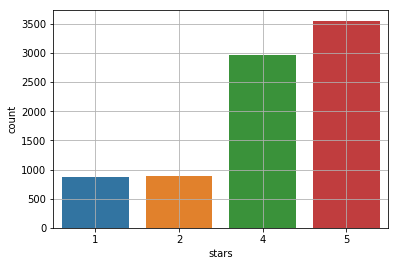

In [64]:
sns.countplot('stars', data=extreme_reviews)
plt.grid()
plt.show()

We will train the classifiers using the best parameters found in the previous sections.

In [65]:
np.random.seed(0)
X_train_review, X_test_review, y_train_review, y_test_review = \
    train_test_split(extreme_reviews.text.values, extreme_reviews.positive.values, test_size=.1)
    
tv = TfidfVectorizer(stop_words='english')
dtm_train = tv.fit_transform(X_train_review)
dtm_test = tv.transform(X_test_review)
print('Number of features from TFIDFVectorizer: %d' % len(tv.get_feature_names()))

Number of features from TFIDFVectorizer: 26985


In [66]:
%%time

lr = LogisticRegression(penalty='l1', C=2)
lr.fit(dtm_train, y_train_review)

print(metrics.classification_report(y_test_review, lr.predict(dtm_test), digits=3))

             precision    recall  f1-score   support

      False      0.942     0.670     0.783       194
       True      0.907     0.987     0.946       635

avg / total      0.915     0.913     0.908       829

CPU times: user 78.7 ms, sys: 3.82 ms, total: 82.5 ms
Wall time: 81.3 ms


In [67]:
%%time

svc = LinearSVC(C=.2)
svc.fit(dtm_train, y_train_review)

print(metrics.classification_report(y_test_review, svc.predict(dtm_test), digits=3))

             precision    recall  f1-score   support

      False      0.952     0.608     0.742       194
       True      0.892     0.991     0.939       635

avg / total      0.906     0.901     0.893       829

CPU times: user 31.2 ms, sys: 1.93 ms, total: 33.1 ms
Wall time: 31.3 ms


In [68]:
%%time

nb = MultinomialNB(alpha=.02)
nb.fit(dtm_train, y_train_review)

print(metrics.classification_report(y_test_review, nb.predict(dtm_test), digits=3))

             precision    recall  f1-score   support

      False      0.867     0.469     0.609       194
       True      0.858     0.978     0.914       635

avg / total      0.860     0.859     0.842       829

CPU times: user 6.13 ms, sys: 1.51 ms, total: 7.64 ms
Wall time: 6.43 ms


As expected performance is now much better.  The algorithm is able to tell the difference between positive and negative reviews with over 90% accuracy in the case of logistic regression.  Logistic regression seems to be performing the best among the three candidate models, so we will continue with that.

### Optimizing the Vectorizer

Now that we have a classifier picked out, we will revisit the vectorizer to see if we can get any improvements by adjusting the paramenters.

In [69]:
%%time

pipe = Pipeline([
    ('vect', TfidfVectorizer(stop_words='english')), 
    ('clf', LogisticRegression(penalty='l1', C=2))
])

param_grid = {
    'vect__ngram_range': [(1,1), (1,2)],
    'vect__max_df': [.25, .4, .8, 1.0],
    'vect__min_df': [0.0, .1, .2]
}

grid = GridSearchCV(pipe, param_grid)
grid.fit(X_train_review, y_train_review)
print('\nBest parameters: ' + str(grid.best_params_))
#print(grid.grid_scores_)
print(metrics.classification_report(y_test_review, grid.predict(X_test_review), digits=3))


Best parameters: {'vect__max_df': 0.4, 'vect__min_df': 0.0, 'vect__ngram_range': (1, 1)}
             precision    recall  f1-score   support

      False      0.942     0.670     0.783       194
       True      0.907     0.987     0.946       635

avg / total      0.915     0.913     0.908       829

CPU times: user 1min 20s, sys: 1.62 s, total: 1min 21s
Wall time: 1min 21s


Note that we did did not get any noticeable improvement in F1.  However, we were able to get this score with with the maximum document frequency set 0.4.  That means we are ignoring the top *60%* of the most frequent words.

### Stemming

Let's see if we can push some more performance out by stemming the input.

In [70]:
ps = PorterStemmer()
def stem(s):
    return ' '.join(ps.stem(x) for x in s.split(' '))

In [71]:
%%time

tv_stem = TfidfVectorizer(stop_words='english', max_df=.4)
dtm_train_stem = tv_stem.fit_transform(map(stem, X_train_review))
dtm_test_stem = tv_stem.transform(map(stem, X_test_review))
print('Number of features from CountVectorizer: %d' % len(tv.vocabulary_))

lr_stem = LogisticRegression(penalty='l1', C=2)
lr_stem.fit(dtm_train_stem, y_train_review)

print(metrics.classification_report(y_test_review, lr_stem.predict(dtm_test_stem), digits=3))

Number of features from CountVectorizer: 26985
             precision    recall  f1-score   support

      False      0.929     0.675     0.782       194
       True      0.908     0.984     0.945       635

avg / total      0.913     0.912     0.907       829

CPU times: user 16.8 s, sys: 23.4 ms, total: 16.8 s
Wall time: 16.9 s


Unfortunately, it looks like stemming did not help in this case.

### What Are we Actually Missing?

Let's take a look at the worst mistakes that the classifier is making see if we can't at least give some reason as to the mistakes.

In [72]:
num_examples = 5

pred = lr.predict(dtm_test)
prob = lr.predict_proba(dtm_test)
R = [(i, max(prob[i]), min(prob[i])) for i, y in enumerate(y_test_review) if y != pred[i]]
R.sort(key=lambda x: -x[1]/x[2])

for _ in range(num_examples):
    for (i, wrong_prob, right_prob) in R:
        if not num_examples: break
        num_examples -= 1
        
        print('Index:', i)
        print('Negative review probability: %3f' % prob[i][0])
        print('Positive review probability: %3f' % prob[i][1])
        print('\n')
        print(X_test_review[i])
        print('\n\n\n')
        

Index: 55
Negative review probability: 0.015845
Positive review probability: 0.984155


I enjoyed the atmosphere and the service was great. However, the food was drenched in oil and really left both my husband and I uninterested in returning. We were so hoping to love this place because as vegans, there are so few healthy restaurants in the valley.




Index: 559
Negative review probability: 0.071537
Positive review probability: 0.928463


When Turntable first opened, they were FANTASTIC! However, they have now gone the way of every other health care provider in the valley. Forget about reaching anyone or having any request taken care of in a timely manner. Used to be able to get same-day appointments - now I have to wait weeks to see anyone.  Some of the health coaches there seem to be sullen and angry - about what I'm not sure, but they are certainly not "coaches" any more. Now I see my primary doctor - Dr. Gokal - has left. He was wonderful. So now I'm wondering why I'm paying $80 a

We notice a lot of mistakes for reviews where the reviewer's expectation is stated but was not met.  We also see some language that may be hard to pick up by a machine learning algorithm (e.g. "did not like" is actually negative despite having the word "like" in it).  It seems that we need some sort of an algorithm that has a memory of what came before and after certain features.  Something like a recurrent neural network...

### Recurrent Neural Network

In this section we will implement a very simple recurrent neural network.  It will consist only 4 layers:
1. An embedding layer for an efficient representation of the training samples
2. A long short term memory layer for the bulk of the prediction power
3. A dropout layer for regularization
4. An output layer

We will also have a checkpoint callback for saving the model.

But first, we need to tokenize the input.  We will use the same number of features as the vocabulary from the TFIDF vectorizer. Also we will only use the first 200 words from each review in order to capture most of the reviews, whilte setting a reasonable limit (recall the below plot).

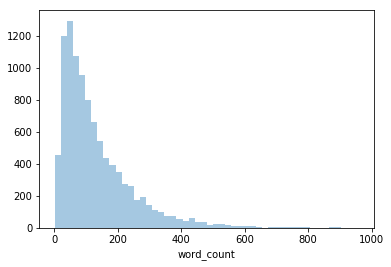

In [73]:
sns.distplot(reviews.word_count, kde=False)

In [74]:
max_features = len(tv.vocabulary_) # use same number of features as TFIDF vectorizer
maxlen = 200 # max words from each review to use

t = Tokenizer(num_words=max_features)
t.fit_on_texts(extreme_reviews['text'])
texts = pad_sequences(t.texts_to_sequences(extreme_reviews['text']), maxlen = maxlen)

Now we can build the model as described above.  We are essentially using the suggested LSTM network suggested [here](https://keras.io/getting-started/sequential-model-guide/).

In [75]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

try: model.load_weights('rnn_weights.hdf5') # load weights if they exist
except: pass

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint = ModelCheckpoint(monitor='val_loss', save_best_only=True, filepath='rnn_weights.hdf5')

Create some new training and test sets.

In [76]:
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = \
    train_test_split(texts, extreme_reviews.positive.values, test_size=.1)

Train the model and output the accuracy.

In [77]:
model.fit(X_train_rnn, y_train_rnn, epochs=10, batch_size=64, callbacks=[checkpoint], validation_split=.1)

print('Test')
score = model.evaluate(X_test_rnn, y_test_rnn, batch_size=64)
print('Loss = %.4f' % score[0])
print('Accuracy = %.4f' % score[1])

Train on 6709 samples, validate on 746 samples
Epoch 1/10
6709/6709 [==============================] - 27s 4ms/step - loss: 0.4411 - acc: 0.8165 - val_loss: 0.3216 - val_acc: 0.8633
Epoch 2/10
6709/6709 [==============================] - 26s 4ms/step - loss: 0.2280 - acc: 0.9130 - val_loss: 0.3029 - val_acc: 0.8941
Epoch 3/10
6709/6709 [==============================] - 27s 4ms/step - loss: 0.1547 - acc: 0.9465 - val_loss: 0.3417 - val_acc: 0.8713
Epoch 4/10
6709/6709 [==============================] - 27s 4ms/step - loss: 0.1039 - acc: 0.9612 - val_loss: 0.2997 - val_acc: 0.8914
Epoch 5/10
6709/6709 [==============================] - 26s 4ms/step - loss: 0.0773 - acc: 0.9757 - val_loss: 0.3859 - val_acc: 0.8887
Epoch 6/10
6709/6709 [==============================] - 26s 4ms/step - loss: 0.0542 - acc: 0.9832 - val_loss: 0.3988 - val_acc: 0.8954
Epoch 7/10
6709/6709 [==============================] - 26s 4ms/step - loss: 0.0410 - acc: 0.9872 - val_loss: 0.6225 - val_acc: 0.8552
Epoch 8/

After quite a long time of training, we end up with performance that is not even as good as naive Bayes.  This is probably an artifact of the simplicity of the model.  Also we are not using very much training data here.

### Load more data

In this section we load some more data (10X what we've been developing with) and see how that affects the results.

In [78]:
more_reviews = pd.read_csv('input/yelp_review.csv', nrows=100000)

In [79]:
%%time
more_reviews['positive'] = more_reviews.stars > 3

np.random.seed(0)
X_train_review2, X_test_review2, y_train_review2, y_test_review2 = \
    train_test_split(more_reviews.text.values, more_reviews.positive.values, test_size=.1)
    
tv = TfidfVectorizer(stop_words='english')
dtm_train2 = tv.fit_transform(X_train_review2)
dtm_test2 = tv.transform(X_test_review2)
print('Number of features from TFIDFVectorizer: %d' % len(tv.get_feature_names()))

Number of features from TFIDFVectorizer: 83781
CPU times: user 6.44 s, sys: 174 ms, total: 6.62 s
Wall time: 6.62 s


In [80]:
%%time

lr = LogisticRegression(penalty='l1', C=2)
lr.fit(dtm_train2, y_train_review2)

print(metrics.classification_report(y_test_review2, lr.predict(dtm_test2), digits=3))
print('Accuracy:', metrics.accuracy_score(y_test_review2, lr.predict(dtm_test2)))

             precision    recall  f1-score   support

      False      0.858     0.787     0.821      3326
       True      0.898     0.935     0.916      6674

avg / total      0.885     0.886     0.884     10000

Accuracy: 0.8858
CPU times: user 2.06 s, sys: 74.1 ms, total: 2.14 s
Wall time: 2.14 s


In [81]:
%%time

max_features = 26985 # use same number of features as previous TFIDF vectorizer
maxlen = 200 # max words from each review to use

t = Tokenizer(num_words=max_features)
t.fit_on_texts(more_reviews['text'])
texts = pad_sequences(t.texts_to_sequences(more_reviews['text']), maxlen = maxlen)

model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

try: model.load_weights('rnn_weights.hdf5') # load weights if they exist
except: pass

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint = ModelCheckpoint(monitor='val_loss', save_best_only=True, filepath='rnn_weights.hdf5')

X_train_rnn2, X_test_rnn2, y_train_rnn2, y_test_rnn2 = \
    train_test_split(texts, more_reviews.positive.values, test_size=.1)

CPU times: user 14.9 s, sys: 471 ms, total: 15.4 s
Wall time: 14.8 s


In [82]:
model.fit(X_train_rnn2, y_train_rnn2, epochs=10, batch_size=64, callbacks=[checkpoint], validation_split=.1)

print('Test')
score = model.evaluate(X_test_rnn2, y_test_rnn2, batch_size=64)
print('Loss = %.4f' % score[0])
print('Accuracy = %.4f' % score[1])

Train on 81000 samples, validate on 9000 samples
Epoch 1/10
81000/81000 [==============================] - 312s 4ms/step - loss: 0.3383 - acc: 0.8584 - val_loss: 0.3101 - val_acc: 0.8609
Epoch 2/10
81000/81000 [==============================] - 312s 4ms/step - loss: 0.2481 - acc: 0.9019 - val_loss: 0.2944 - val_acc: 0.8667
Epoch 3/10
81000/81000 [==============================] - 312s 4ms/step - loss: 0.2177 - acc: 0.9155 - val_loss: 0.2399 - val_acc: 0.9048
Epoch 4/10
81000/81000 [==============================] - 321s 4ms/step - loss: 0.1965 - acc: 0.9236 - val_loss: 0.2356 - val_acc: 0.9067
Epoch 5/10
81000/81000 [==============================] - 316s 4ms/step - loss: 0.1787 - acc: 0.9315 - val_loss: 0.2380 - val_acc: 0.9046
Epoch 6/10
81000/81000 [==============================] - 314s 4ms/step - loss: 0.1617 - acc: 0.9386 - val_loss: 0.2404 - val_acc: 0.9074
Epoch 7/10
81000/81000 [==============================] - 1681s 21ms/step - loss: 0.1475 - acc: 0.9449 - val_loss: 0.2548 -

Unfortunately we did not improve the accuracy on the logistic regression or neural network model.  Some work needs to be done on the structure of the neural network.

# Section 3 - Unsupervised Learning - Kmeans

In this section the we explore geographic features of businesses according to their star ratings and categories using Kmeans. The rationale for location based exploration of yelp reviews is the assumption that reviews depend on location factors, such as nearby businesses and capital costs.

In [83]:
def map_it(df,zoom,sample):
    
    '''
    df = dataframe with 'latitude' and 'longitude' columns
    sample = size of coordinates to sample
    '''
    mapcenter = [df.latitude.mean(), df.longitude.mean()]
    p = folium.Map(location=mapcenter,
                            tiles = "Stamen Toner",
                            zoom_start = zoom) 
    p.add_child(MeasureControl())
    plugins.Fullscreen(
        position='topright',
        title='Expand me',
        title_cancel='Exit me',
        force_separate_button=True).add_to(p)
    # Ensure you're handing it floats
    df['latitude'] = df['latitude'].astype(float)
    df['longitude'] = df['longitude'].astype(float)
    # Filter the DF for rows, then columns, then remove NaNs
    heat_df = df.sample(sample)
    heat_df = heat_df[['latitude', 'longitude']]
    heat_df = heat_df.dropna(axis=0, subset=['latitude','longitude'])
    # List comprehension to make out list of lists
    heat_data = [[row['latitude'],row['longitude']] for index, row in heat_df.iterrows()]
    # Plot it on the map
    HeatMap(heat_data).add_to(p)
    # Display the map
    return p

> Load & Preprocess Data

In [85]:
%%time
# import zillow data
zillow = pd.read_csv('input/Zip_MedianListingPrice_AllHomes.csv')

CPU times: user 138 ms, sys: 24.1 ms, total: 162 ms
Wall time: 164 ms


In [86]:
# bin star ratings 1 - 5
businesses['stars'] = pd.cut(businesses.stars, bins=5, labels=range(1,6))
businesses['stars'] = businesses['stars'].astype(int)

> Data Joins

In [87]:
# joins yelp & zillow data
zillow['postal_code'] = zillow['RegionName']
zillow['postal_code'] = list(map(str,zillow.postal_code))
joined_yz = joined.merge(zillow, on='postal_code')

> Data Subset | by 5 most reviewed cities

In [88]:
# top cities merged with zillow
top_star_cities_lst = joined.groupby('city').count().sort_values(by='name', ascending=False).head(5).index.tolist()
city=joined.loc[joined['city'].isin(top_star_cities_lst)]
#city['city_code'] = pd.Categorical(city.city)
#city['city_code'] = city['city_code'].cat.codes
city = city.reset_index(drop=True)
city = city.merge(zillow, on='postal_code')
city['median_home'] = city.iloc[:,172:-18].sum(axis=1) # by zip
city['stars_'] = pd.cut(city.stars, bins=5, labels=range(1,6))
city_color = city
print('city_df shape: rows: {} columns: {}'.format(city.shape[0],city.shape[1]))

city_df shape: rows: 43068 columns: 194


> EDA

The yelp datasets span cities in North America and Europe:

In [89]:
map_it(joined ,1,3000)

61 "states" are represented in the data set.  The states listed include terrorities. 
The reviews are distributed unevenly across the dataset:

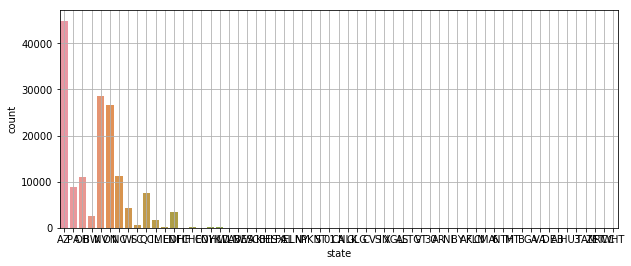

In [90]:
fig, ax = plt.subplots(figsize=(10,4))
sns.countplot('state', data=joined, ax=ax)
plt.grid()
plt.show()

There are 11 "states" that contain records over 1000.  There are five cities with over 10000 records.  

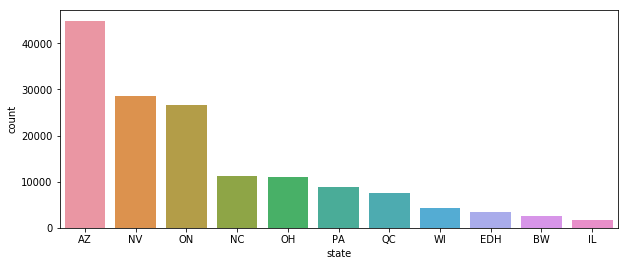

In [91]:
pd.DataFrame(joined.groupby('state')['name'].count()).sort_values(by='name', ascending=False).rename(columns={'name':'count'}).head(20).T
fig, ax = plt.subplots(figsize=(10,4))
dfr=pd.DataFrame(joined.groupby('state')['state'].count()).rename(
    columns={'state':'count'}).astype(int).reset_index().sort_values(by='count', ascending=False)
sns.barplot(x='state', y='count',data = dfr[dfr['count'] > 1000], ax=ax)

The median star count varies between the states from 5 to 2:

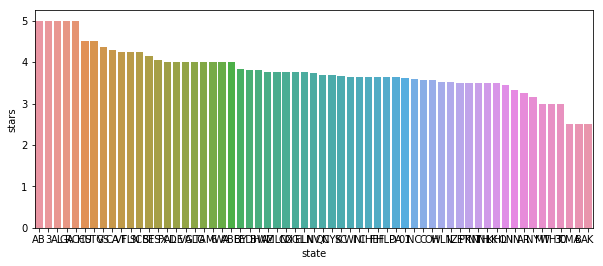

In [92]:
star_count = pd.DataFrame(joined.groupby('state')['stars'].mean()).sort_values(
    by='stars', ascending=False)
fig, ax = plt.subplots(figsize=(10,4))
sns.barplot(x="state", y="stars", data=star_count.reset_index(), ci=68, ax=ax);

> Stars by City | counts

The distribution of stars varies from city to city.  The 5 most frequently rated cities displayed varied distributions.  Las Vegas, Charlotte and Scottsdale have a particularly high count of 4 and 5 star ratings where Charlotte and Toronto  have fewer 5 star ratings:

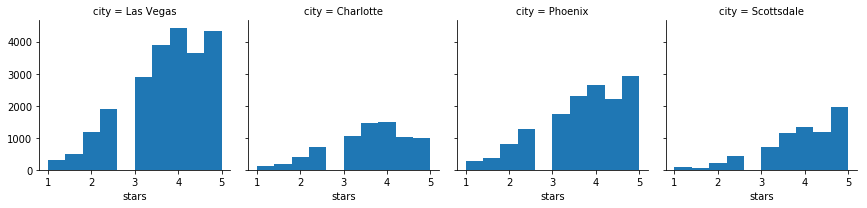

In [93]:
# top_star_cities_lst.remove('Toronto')
top_star_cities_lst.remove('Toronto')
top_star_cities_df = joined.loc[joined['city'].isin(top_star_cities_lst)]
g = sns.FacetGrid(top_star_cities_df, col="city", col_wrap=5)
g = g.map(plt.hist, "stars")


The geographic distribution of stars appear to be uniformly distributed across these cities:

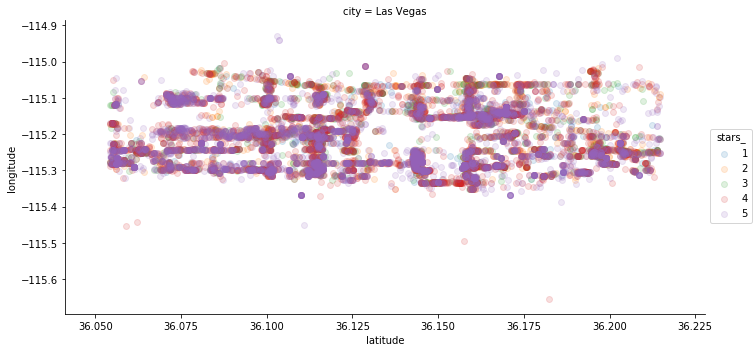

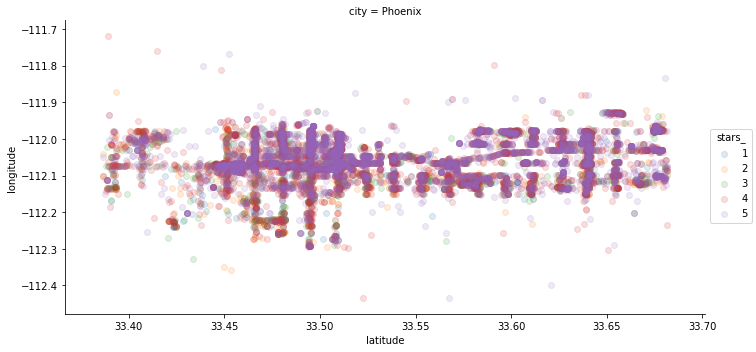

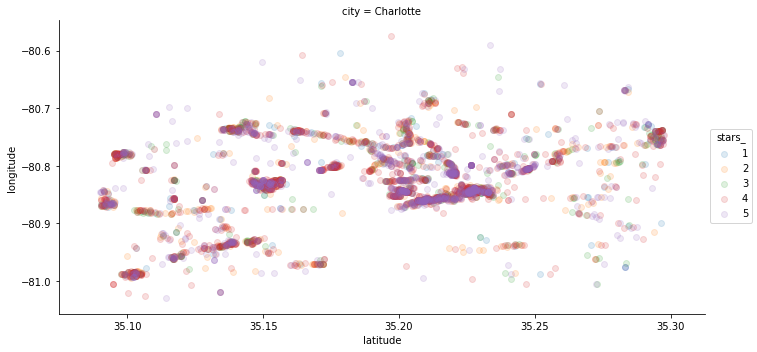

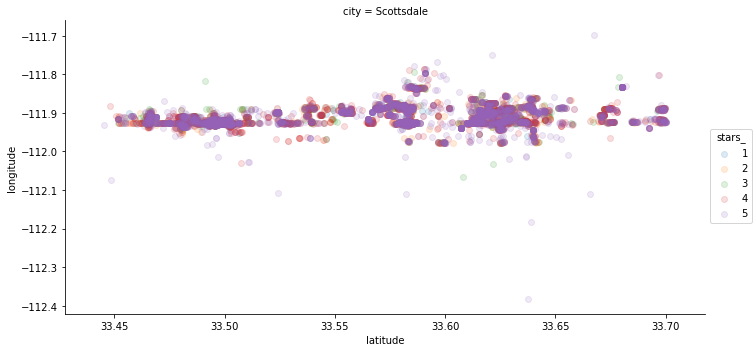

In [94]:
for i in top_star_cities_lst:
    cen=2
    df = city_color.loc[city_color.city.isin([i])]
    # for las vegas  df = city[(city.latitude > 0) & (city.longitude < -100) & (city.latitude > 35) & (city.longitude > -116) ]
    df1 = df[(df.latitude < df.latitude.mean() + df.latitude.std(0)) 
& (df.latitude >  df.latitude.mean() - df.latitude.std(0))
& (df.longitude < df.longitude.mean() + cen*df.longitude.std(0))
& (df.longitude >  df.longitude.mean() - cen*df.longitude.std(0))]
    sns.lmplot( x="latitude", y="longitude", data=df1, fit_reg=False, 
           legend=True, size=5, aspect=2, hue='stars_', col = 'city', scatter_kws={'alpha':0.15});

Stars appear to be geographically evenly distributed in each city when split:

Las Vegas


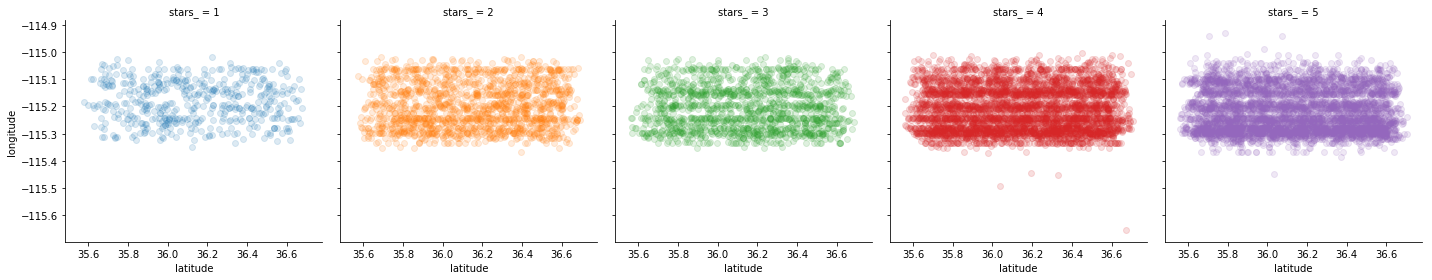

Phoenix


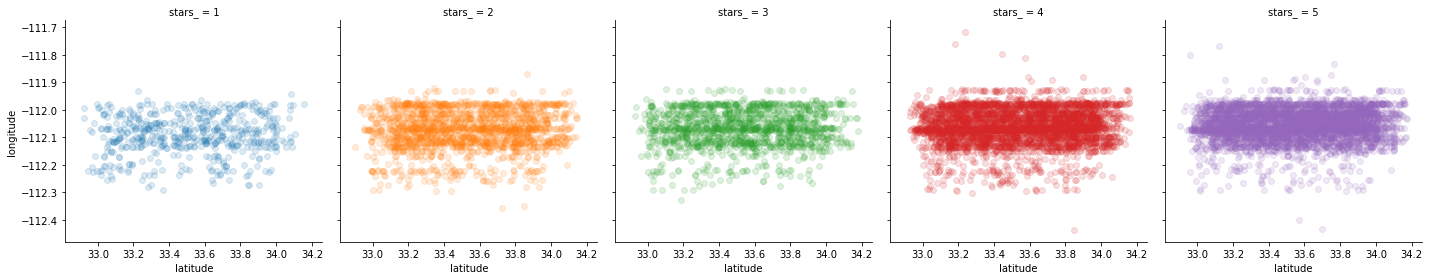

Charlotte


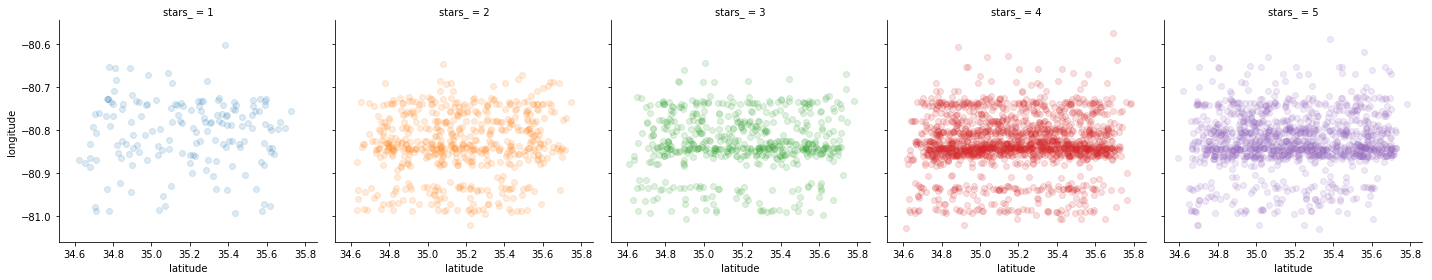

Scottsdale


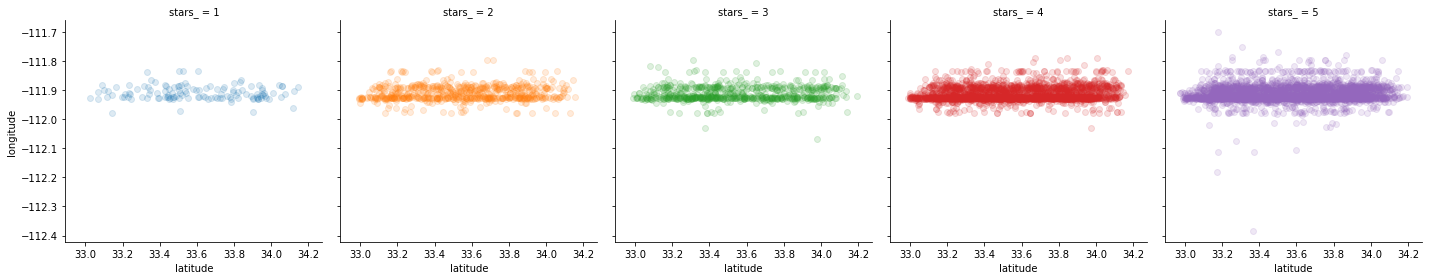

In [95]:

# stars by city by location
for i in top_star_cities_lst:
    print(i)
    cen=2
    df = city_color.loc[city_color.city.isin([i])]
    # for las vegas  df = city[(city.latitude > 0) & (city.longitude < -100) & (city.latitude > 35) & (city.longitude > -116) ]
    df1 = df[(df.latitude < df.latitude.mean() + df.latitude.std(0)) 
& (df.latitude >  df.latitude.mean() - df.latitude.std(0))
& (df.longitude < df.longitude.mean() + cen*df.longitude.std(0))
& (df.longitude >  df.longitude.mean() - cen*df.longitude.std(0))]
    
    sns.lmplot( x="latitude", y="longitude", data=df1, fit_reg=False, 
           legend=True, size=4, aspect=1, hue='stars_', col = 'stars_', x_jitter=.5,col_wrap=5,scatter_kws={'alpha':0.15})
    plt.show();


# Kmeans

In [96]:
def min_max_scaling(df):
    '''
    Preprocesses dataframe to normalize values before applying kmeans
    '''
    cols = df.columns
    df = df.fillna(1)
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.StandardScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    df.columns = cols
    return df

def elbow_chart(df,clust_test):
    '''
    Displays the elbow for selecting the right n for kmeans
    Takes a numeric data frame runs kmeans through range in clust_test parameter
    '''
    error = np.zeros(clust_test+1)
    error[0] = 0;
    for k in range(1,clust_test+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(df)
        error[k] = kmeans.inertia_
    plt.figure(1)
    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')
    plt.show()
    return error

# Las Vegas
def city_bbox(df,city_name):    
    '''takes dataframe and makes bounding box according to density of reviews, and returns a df subset by city'''
    df = df.query('city == "{}"'.format(city_name))
    city_df = df[(df.latitude < df.latitude.mean() + df.latitude.std(0)) 
& (df.latitude >  df.latitude.mean() - df.latitude.std(0))
& (df.longitude < df.longitude.mean() + cen*df.longitude.std(0))
& (df.longitude >  df.longitude.mean() - cen*df.longitude.std(0))]
    return city_df

def pre_process_by_city(df,city_name,feature_lst):
    '''
    takes city, city name, and a list of features as arguments and returns X for kmeans
    '''
    c = df.query('city == "{}"'.format(city_name))
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    num_c = c.select_dtypes(include=numerics)
    X = min_max_scaling(num_c)
    X = X[feature_lst] # 'longitude','latitude']
    return X

def city_clusters(df,city_name,feature_lst):
    '''takes a dataframe, city name, and returns kmeans labels and cluster centers'''
    X = pre_process_by_city(df,city_name,feature_lst)
    kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
    return kmeans.labels_, kmeans.cluster_centers_

The best n varies by city:

Las Vegas


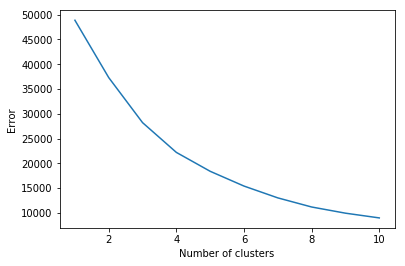

Phoenix


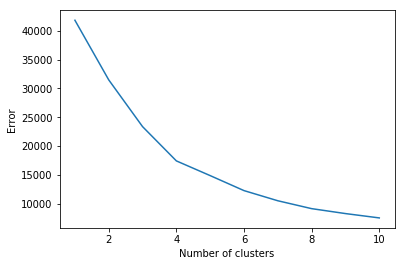

Charlotte


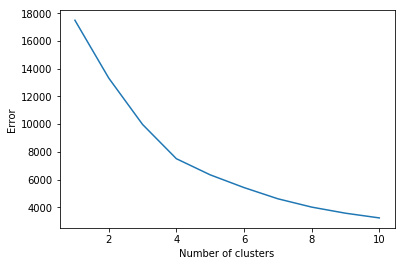

Scottsdale


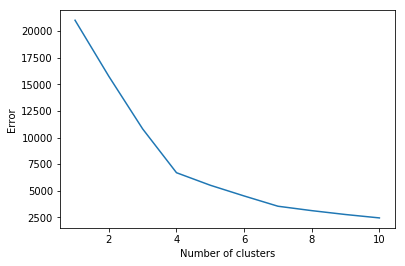

In [97]:
# identifying the right n for kmeans
feature_lst = ['stars','review_count','median_home']
for city_name in top_star_cities_lst:
    print(city_name)
    X = pre_process_by_city(city,city_name,feature_lst)
    error = elbow_chart(X,10)

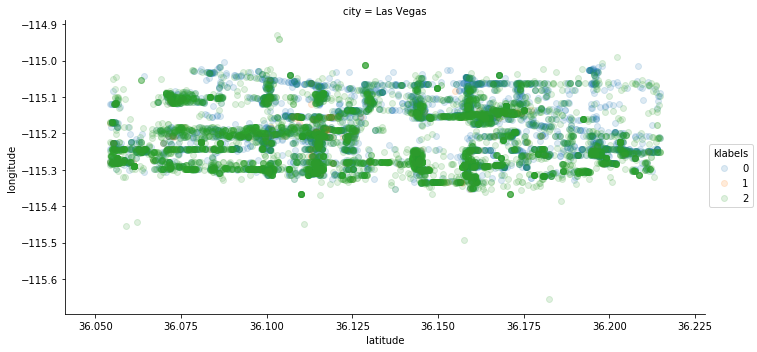

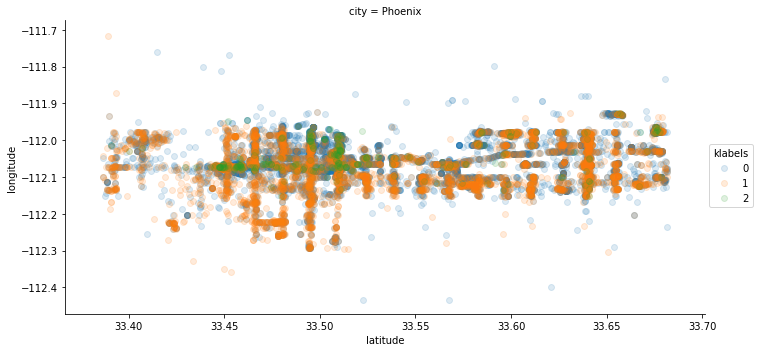

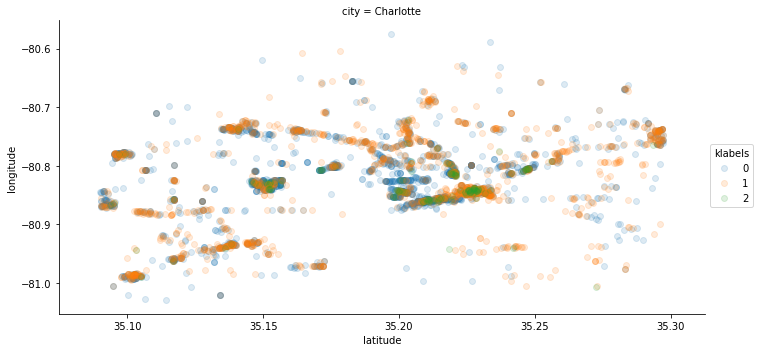

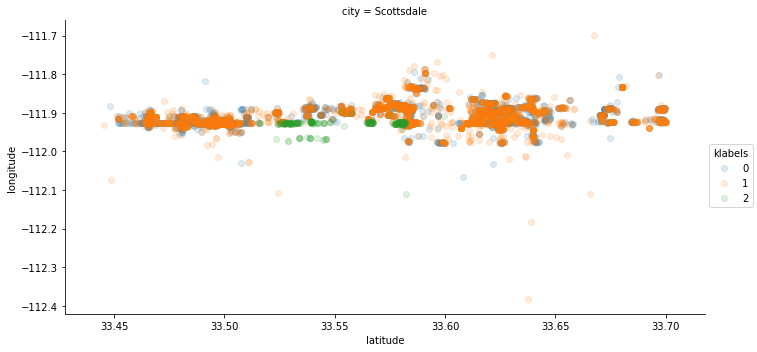

In [98]:
for city_name in top_star_cities_lst:
    df = city_bbox(city,city_name)
    df['klabels'],centers=city_clusters(df,city_name, feature_lst)
    g = sns.lmplot( x="latitude", y="longitude", data=df, fit_reg=False, 
        legend=True, size=5, aspect=2, hue='klabels', col = 'city', scatter_kws={'alpha':0.15});